PyTorch version: 2.7.1+cpu
GPU Available: False
Loading MNIST dataset...
Training data size: 60000
Test data size: 10000
Number of classes: 10
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.

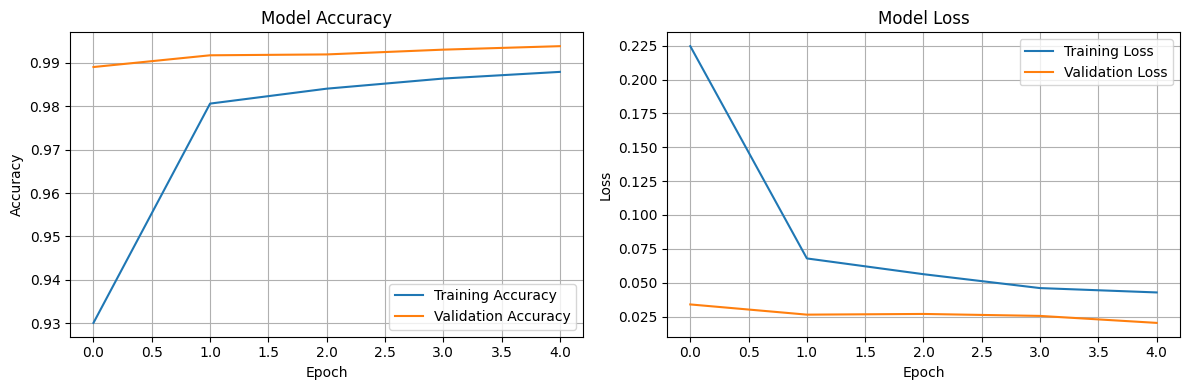

Test Accuracy: 0.9938 (99.38%)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



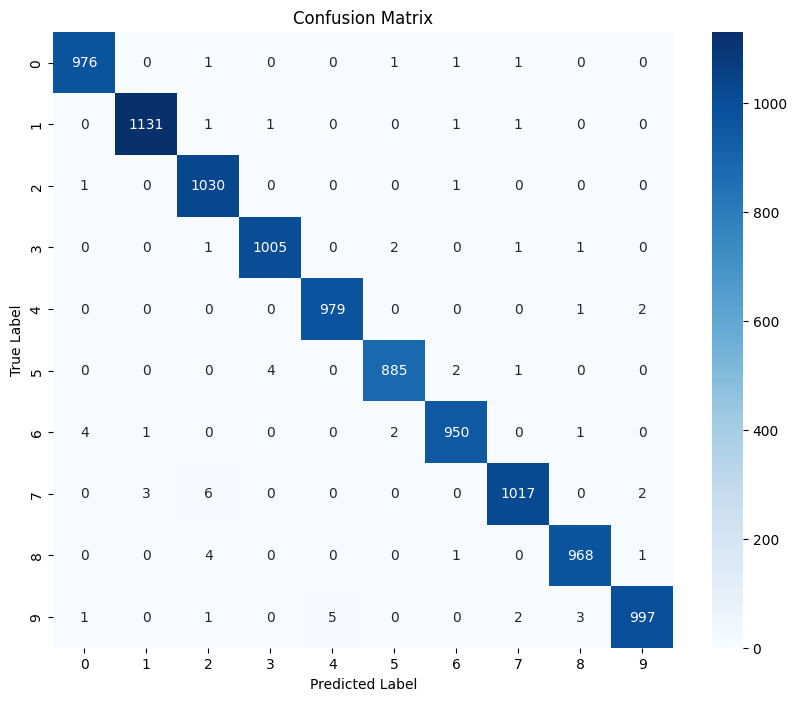


Visualizing predictions on 5 sample images:


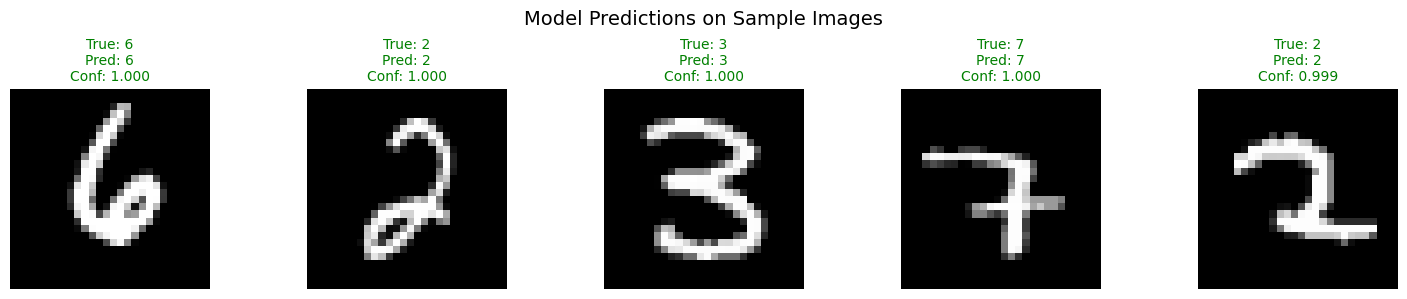


Analyzing per-digit performance:


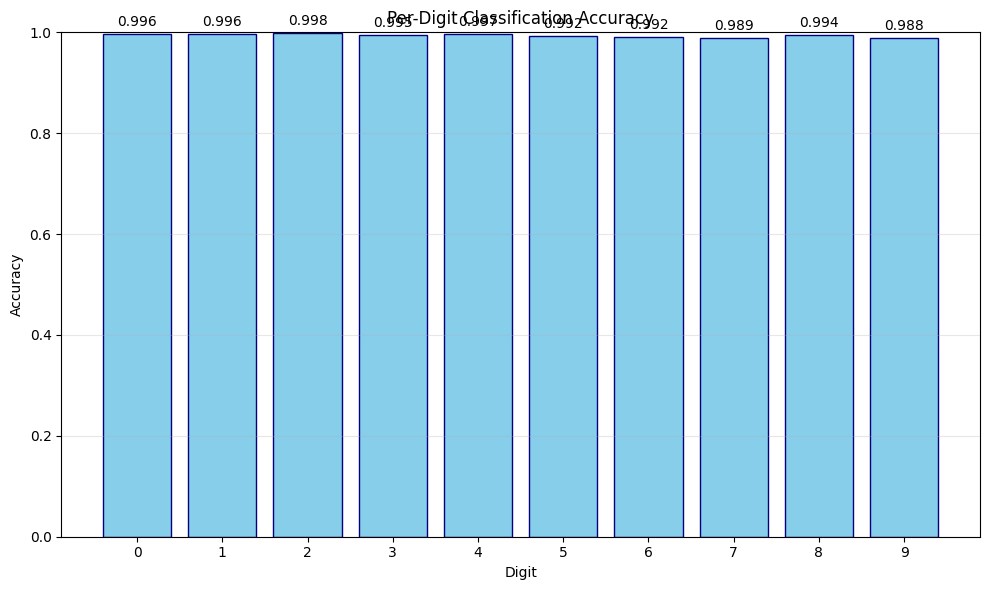


Summary Statistics:
Overall Test Accuracy: 0.9938
Best Digit Accuracy: 0.9981 (Digit 2)
Worst Digit Accuracy: 0.9881 (Digit 9)
Average Per-Digit Accuracy: 0.9937

Saving model...
Model saved as 'mnist_cnn_model.pth'

MNIST CNN Classification Complete!
Final Test Accuracy: 99.38%
🎉 Successfully achieved >95% accuracy target!


In [1]:
# MNIST Handwritten Digits Classification with CNN (PyTorch Version)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch version:", torch.__version__)
print("GPU Available:", torch.cuda.is_available())

# Load and preprocess the MNIST dataset
print("Loading MNIST dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training data size: {len(train_dataset)}")
print(f"Test data size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

# Build the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.drop3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.drop5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.bn3(self.conv5(x)))
        x = self.drop3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop4(x)
        x = F.relu(self.fc2(x))
        x = self.drop5(x)
        x = self.fc3(x)
        return x

model = CNN().to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot training history
def plot_training_history(train_accs, val_accs, train_losses, val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_accs, label='Training Accuracy')
    ax1.plot(val_accs, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(train_accs, val_accs, train_losses, val_losses)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize predictions on 5 sample images
def visualize_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_input)
            pred_label = output.argmax(dim=1).item()
            confidence = F.softmax(output, dim=1).max().item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        color = 'green' if true_label == pred_label else 'red'
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}'
        axes[i].set_title(title, color=color, fontsize=10)
    plt.suptitle('Model Predictions on Sample Images', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nVisualizing predictions on 5 sample images:")
visualize_predictions(model, test_dataset, 5)

# Per-digit accuracy
def analyze_per_digit_performance(y_true, y_pred):
    accuracy_per_digit = []
    for digit in range(10):
        digit_mask = (y_true == digit)
        digit_accuracy = np.mean(y_pred[digit_mask] == digit)
        accuracy_per_digit.append(digit_accuracy)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), accuracy_per_digit, color='skyblue', edgecolor='navy')
    plt.xlabel('Digit')
    plt.ylabel('Accuracy')
    plt.title('Per-Digit Classification Accuracy')
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    return accuracy_per_digit

print("\nAnalyzing per-digit performance:")
digit_accuracies = analyze_per_digit_performance(all_labels, all_preds)

print(f"\nSummary Statistics:")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Best Digit Accuracy: {max(digit_accuracies):.4f} (Digit {np.argmax(digit_accuracies)})")
print(f"Worst Digit Accuracy: {min(digit_accuracies):.4f} (Digit {np.argmin(digit_accuracies)})")
print(f"Average Per-Digit Accuracy: {np.mean(digit_accuracies):.4f}")

# Optional: Save the model
print("\nSaving model...")
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print("Model saved as 'mnist_cnn_model.pth'")

print("\n" + "="*50)
print("MNIST CNN Classification Complete!")
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
if test_accuracy > 0.95:
    print("🎉 Successfully achieved >95% accuracy target!")
print("="*50)